In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nltk

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from gensim.models import Word2Vec
import pickle

Mengambil Word2Vec

In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/deep learning/Dataset Analisis Sentimen - After Labeling.csv'
df = pd.read_csv(csv_path)

total_tasks = len(df)
max_threads = 1

In [ ]:
df

,Unnamed: 0,Komentar,Timestap,Sumber,Label
0,1,Batalkan saja. Rakyat Indonesia sudah muak dg ...,31/10/2024,YouTube,Negative
1,2,punya pacar ngga ada otak ngerendahin ibu gue ...,08/11/2024,X,Negative
2,3,Kalau lu masih nge pertahanin ya lu juga gaada...,08/11/2024,X,Negative
3,4,"Beasiswa tapi beli tas Hermes, naik jet pribad...",31/10/2024,YouTube,Negative
4,5,stop bikin tweet yang membuat gua mikir di nih...,08/11/2024,X,Negative
...,...,...,...,...,...
1015,1016,"minusnya apa sih ni orang,perfect bgt masyaallah",28/11/2024,TikTok,Positive
1016,1017,syukurlah lagunya ceria klo ngga capek bgt mew...,28/11/2024,TikTok,Positive
1017,1018,"pak TIW dah potong rambut , wajah nya makin se...",28/11/2024,TikTok,Positive
1018,1019,klu uda pernh ke nduga berarti keren ...aku aj...,28/11/2024,TikTok,Positive


In [ ]:
import re

def clean_sentence(sentence):
    # Hapus tanda baca dan emoji
    sentence = re.sub(r'[^\w\s]', '', sentence)  # Hapus tanda baca
    return sentence.lower()  # Ubah ke huruf kecil


In [ ]:
list_komen = df['Komentar'].dropna().tolist()
for i in range(len(list_komen)):
    list_komen[i] = list_komen[i].lower()





In [ ]:
list_komen

['batalkan saja. rakyat indonesia sudah muak dg keluarga ini',
 'punya pacar ngga ada otak ngerendahin ibu gue ajggggg',
 'kalau lu masih nge pertahanin ya lu juga gaada otak',
 'beasiswa tapi beli tas hermes, naik jet pribadi, tidak lagi punya malu. orang model gini suruh ke laut saja.',
 'stop bikin tweet yang membuat gua mikir di nih komun anjing tanya aja sama bapak ko, gua cmn mau liat orang marah2 aja ya ajing',
 'ni mantu bungsu butuh banget validasi kalo dia mantu presiden...maklumi sj okb',
 'pagi pagi udah kaya tai aja',
 'gw kesel bgt sama bokap anjinggg, capek ngurusin orang kena azab bangsat',
 'ngadepin orang mudah marah tuh gimana si anj? 😭😭 energi gue ampe abisss asuuuu',
 'netizen ini lucu. beasiswa dari kampus kok dikira dari negara. \n dikira beasiswa tidak mampu apa gimana. wkwkwk',
 'dia berpikir gua cewek murahan, kagak anjing, jangan samain gua sama cewek² yg pernah lo icip, setan lo anjj',
 'punya temen mabar hari-hari nelfon buat nobar bokep, ajg dikira gw jabl

Membuat Token

In [ ]:
import spacy

# Memuat model SpaCy sekali saja di luar loop
nlp = spacy.load("en_core_web_sm")

# Proses tokenisasi untuk semua komentar
list_komen_token = [nlp(komen) for komen in list_komen]
list_komen_token = [[token.text for token in doc] for doc in list_komen_token]

In [ ]:

print(list_komen_token)

[['batalkan', 'saja', '.', 'rakyat', 'indonesia', 'sudah', 'muak', 'dg', 'keluarga', 'ini'], ['punya', 'pacar', 'ngga', 'ada', 'otak', 'ngerendahin', 'ibu', 'gue', 'ajggggg'], ['kalau', 'lu', 'masih', 'nge', 'pertahanin', 'ya', 'lu', 'juga', 'gaada', 'otak'], ['beasiswa', 'tapi', 'beli', 'tas', 'hermes', ',', 'naik', 'jet', 'pribadi', ',', 'tidak', 'lagi', 'punya', 'malu', '.', 'orang', 'model', 'gini', 'suruh', 'ke', 'laut', 'saja', '.'], ['stop', 'bikin', 'tweet', 'yang', 'membuat', 'gua', 'mikir', 'di', 'nih', 'komun', 'anjing', 'tanya', 'aja', 'sama', 'bapak', 'ko', ',', 'gua', 'cmn', 'mau', 'liat', 'orang', 'marah2', 'aja', 'ya', 'ajing'], ['ni', 'mantu', 'bungsu', 'butuh', 'banget', 'validasi', 'kalo', 'dia', 'mantu', 'presiden', '...', 'maklumi', 'sj', 'okb'], ['pagi', 'pagi', 'udah', 'kaya', 'tai', 'aja'], ['gw', 'kesel', 'bgt', 'sama', 'bokap', 'anjinggg', ',', 'capek', 'ngurusin', 'orang', 'kena', 'azab', 'bangsat'], ['ngadepin', 'orang', 'mudah', 'marah', 'tuh', 'gimana', 's

Membuat Model

In [ ]:
word2vec = Word2Vec(list_komen_token, min_count=1, vector_size=300)
word2vec.save("my_word2vec.model")

vocab = list(word2vec.wv.index_to_key)
embedding_dim = word2vec.vector_size
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}
pretrained_embeddings = np.array([word2vec.wv[word] for word in vocab])

Model CBOW

In [ ]:
class SentimentCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings):
        super(SentimentCBOW, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings, dtype=torch.float32))
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, 2)  # Two classes: negative and positive

    def forward(self, inputs):
        # Compute the mean of word embeddings in the sentence
        embeds = self.embeddings(inputs)
        sentence_embed = embeds.mean(dim=0).view(1, -1)
        out = F.relu(self.fc1(sentence_embed))
        out = self.fc2(out)
        return F.log_softmax(out, dim=-1)

In [ ]:
def make_sentence_vector(sentence, word_to_idx):
    """Convert a sentence into a list of word indices."""
    words = sentence.split()
    return torch.tensor([word_to_idx[word] for word in words if word in word_to_idx], dtype=torch.long)

In [ ]:
list_label = df['Label'].dropna().tolist()
for i in range(len(list_label)):
    if list_label[i] == 'Negative':
        list_label[i] = 0
    else:
        list_label[i] = 1

list_komen_label = [(list_komen[i], list_label[i]) for i in range(len(list_komen))]




In [ ]:
print(list_komen_label)

[('batalkan saja. rakyat indonesia sudah muak dg keluarga ini', 0), ('punya pacar ngga ada otak ngerendahin ibu gue ajggggg', 0), ('kalau lu masih nge pertahanin ya lu juga gaada otak', 0), ('beasiswa tapi beli tas hermes, naik jet pribadi, tidak lagi punya malu. orang model gini suruh ke laut saja.', 0), ('stop bikin tweet yang membuat gua mikir di nih komun anjing tanya aja sama bapak ko, gua cmn mau liat orang marah2 aja ya ajing', 0), ('ni mantu bungsu butuh banget validasi kalo dia mantu presiden...maklumi sj okb', 0), ('pagi pagi udah kaya tai aja', 0), ('gw kesel bgt sama bokap anjinggg, capek ngurusin orang kena azab bangsat', 0), ('ngadepin orang mudah marah tuh gimana si anj? 😭😭 energi gue ampe abisss asuuuu', 0), ('netizen ini lucu. beasiswa dari kampus kok dikira dari negara. \n dikira beasiswa tidak mampu apa gimana. wkwkwk', 1), ('dia berpikir gua cewek murahan, kagak anjing, jangan samain gua sama cewek² yg pernah lo icip, setan lo anjj', 0), ('punya temen mabar hari-har

Membuat Training

In [ ]:
from sklearn.model_selection import train_test_split


train_sentences, test_sentences = train_test_split(list_komen_label, test_size=0.1, random_state=42)

train_data = [(make_sentence_vector(sentence, word_to_idx), label) for sentence, label in train_sentences if sentence]

# Membuat test_data
test_data = [(make_sentence_vector(sentence, word_to_idx), label) for sentence, label in test_sentences if sentence]


In [ ]:
print(train_data)
print(train_sentences)

[(tensor([192,   7]), 1), (tensor([  82, 2245,  874,    3,  200, 1476, 2241,    1,    1, 2239,   12,   16,
         347,  570,    3,  491,   14,    2, 2237,  491,  363, 2236,   12,  215,
          50,   38,    2,   84,  570,   16,  244,  164, 1477,   72,   40,    3,
         491,   96, 1478,   22, 2234,    3,  428, 1400,   22,  570,  362,   40,
         874,    3,    2, 2259,  112,  175,    5, 2261, 1479,   50]), 0), (tensor([3282,  643, 3309,  214]), 1), (tensor([3131,   15,    2, 3130,  631, 1535,  239,   13, 3129,   80]), 0), (tensor([3307]), 0), (tensor([464]), 1), (tensor([  44,    2, 2470,   91,  301,    7]), 1), (tensor([4002, 1719,  234,  173, 4001, 4000, 1082, 3999,  234, 3998, 3997,  503,
        1668,   29,  117,   90]), 0), (tensor([ 805, 1156, 1483,  103]), 0), (tensor([   7, 3547,  174,  130, 3546,  174, 1157,  439,   78,   31,  325,    2,
         172,  161,  209,    2,  161,  747,  183,  439,  254,    5,  135, 3545,
        3544, 3569,   47,   32,   59, 1326,    3,  439

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_data):
    y_true = []
    y_pred = []

    with torch.no_grad():
        for sentence_vec, label in test_data:
            if sentence_vec.shape[0] == 0:  # Skip invalid sentences
                continue
            output = model(sentence_vec)
            predicted_label = torch.argmax(output, dim=1).item()
            y_pred.append(predicted_label)
            y_true.append(label)

    # Menghitung metrik
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted untuk multiclass
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1


Inisiasi Model

In [ ]:
vocab_size = len(vocab)
model = SentimentCBOW(vocab_size, embedding_dim, pretrained_embeddings)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.NLLLoss()

Training Data

In [ ]:


# Placeholder untuk menyimpan metrik di setiap epoch
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
loss_list = []

# Simulasi pelatihan
epochs = 1000
for epoch in range(epochs):
    for sentence_vec, label in train_data:
        if sentence_vec.shape[0] == 0:  # Skip sentences with no valid words in vocabulary
            continue
        model.zero_grad()
        output = model(sentence_vec)
        loss = loss_function(output, torch.tensor([label], dtype=torch.long))
        loss.backward()
        optimizer.step()
        loss.item()

    # Evaluasi pada test data
    accuracy, precision, recall, f1 = evaluate_model(model, test_data)

    # Simpan hasil evaluasi ke list
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    loss_list.append(loss.item())

    # Print log
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Epoch 1/1000, Loss: 0.6900, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 2/1000, Loss: 0.6753, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 3/1000, Loss: 0.6607, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 4/1000, Loss: 0.6572, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 5/1000, Loss: 0.6582, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 6/1000, Loss: 0.6695, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 7/1000, Loss: 0.6763, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 8/1000, Loss: 0.6818, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 9/1000, Loss: 0.6803, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 10/1000, Loss: 0.6819, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.4902, F1: 0.3600
Epoch 11/1000, Loss: 0.6870, Accuracy: 0.4902, Precision: 0.4474, Recall: 0.490

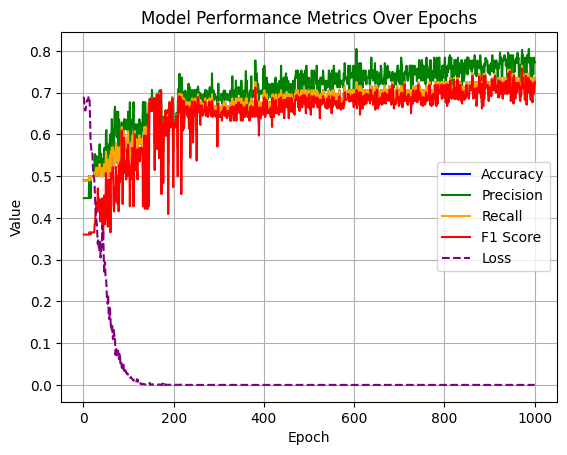

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), accuracy_list, label="Accuracy", color="blue")
plt.plot(range(1, epochs + 1), precision_list, label="Precision", color="green")
plt.plot(range(1, epochs + 1), recall_list, label="Recall", color="orange")
plt.plot(range(1, epochs + 1), f1_list, label="F1 Score", color="red")
plt.plot(range(1, epochs + 1), loss_list, label="Loss", color="purple", linestyle="--")

# Tambahkan label dan judul
plt.title("Model Performance Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.show()

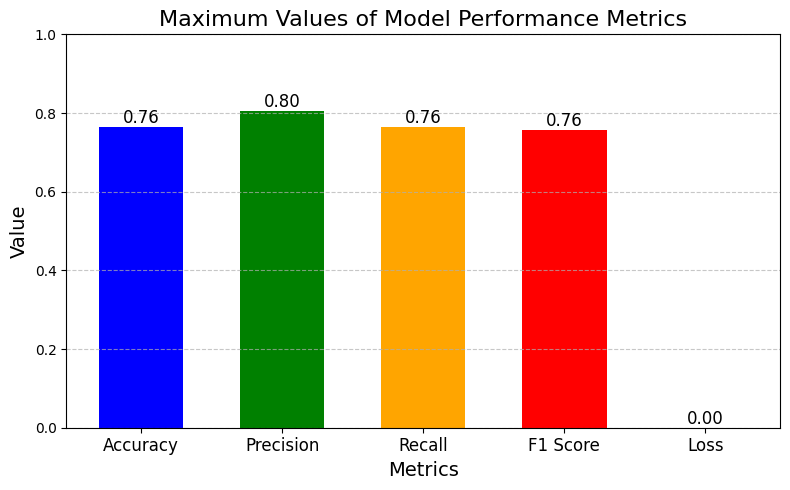

In [ ]:
import numpy as np
import statistics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Loss"]
modus_values = [
    max(accuracy_list),
    max(precision_list),
    max(recall_list),
    max(f1_list),
    statistics.mode(loss_list),
]

# Atur jarak antar bar
x = np.arange(len(metrics))  # Posisi x untuk setiap bar
bar_width = 0.6  # Lebar setiap bar

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(x, modus_values, color=["blue", "green", "orange", "red", "purple"], width=bar_width)

# Tambahkan nilai di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize=12)

# Tambahkan label dan judul
plt.title("Maximum Values of Model Performance Metrics", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(x, metrics, fontsize=12)  # Posisi x diganti nama metrik
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)  # Tambahkan ruang di atas bar

# Tampilkan grafik
plt.tight_layout()
plt.show()

Testing Data

In [ ]:
test_sentence = "jokowi mantan presiden"
test_vec = make_sentence_vector(test_sentence, word_to_idx)
print(test_vec)
if test_vec.shape[0] > 0:
    output = model(test_vec)
    prediction = torch.argmax(output).item()
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Sentence: \"{test_sentence}\"")
    print(f"Predicted Sentiment: {sentiment}")
else:
    print("The test sentence contains words not in the vocabulary.")

tensor([ 636, 4329,  528])
Sentence: "jokowi mantan presiden"
Predicted Sentiment: Positive
